In [82]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from  av.io import read
import pandas as pd
import datetime
import tensorflow as tf
#tf.enable_eager_execution()

from glob import glob
from sklearn.preprocessing import normalize
from tensorflow import keras



In [83]:
use_rotation_sensor = False
if use_rotation_sensor:
    cut_shape = (100, 8)
    normalize_vector = np.array([1,1,1,1,1, 15, 15, 15])
else:
    cut_shape = (100, 3)
    normalize_vector = np.array([15, 15, 15])
gestures = {0: 'Noise', 1: 'Left', 2: 'Right'}

data_folder = "data/"
patterns = {"left" : "swipe_left_20*.mkv", "right" : "swipe_right_20*.mkv", "noise" : "*noise*.mvk"} 
data_split_folder = "data_singled/"

In [148]:
def read_file(filename, lable=None):
    data, meta = read(" ".join(["a:" + str(i) for i in range(4)]), filename, 50)
    datapairs = list(zip(data, meta))
    
    df = pd.DataFrame()
    names = []
    col_name_tpls = []
    for sensor_data, stream_object in datapairs:
        meta_dict = stream_object.metadata
        # print(meta_dict)
        name = meta_dict["NAME"]
        names.append(name)
        n_cols = len(sensor_data)
        col_names = []
        for i in range(n_cols):
            col_name = name + "_" + str(i)
            col_names.append(col_name)
            df[col_name] = pd.Series(sensor_data.T[:,i])
        col_name_tpls.append(col_names)
    df.index = pd.TimedeltaIndex(freq="20ms", start=0.0, periods=len(df))
    return df, col_name_tpls

def trim_data(data_frame, start=0.0, end=None):
    if end:
        df = data_frame[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = data_frame[pd.Timedelta(10**9 * start):]
    return df

def cut_data(data_frame, cuts):
    df_cut_list = np.ndarray(shape=(len(cuts),) + cut_shape)
    for i, cut in enumerate(cuts):
        df_i = data_frame[pd.Timedelta(10**9 * cut[0]):pd.Timedelta(10**9 * cut[1])]
        start_chanel = 0
        
        if not use_rotation_sensor:
            start_chanel = 5
        df_cut_list[i, : , :] = df_i.iloc[0: 100, start_chanel:8]

    return df_cut_list


def find_peaks(df, sensor, start=0.0, end=None, sel_method="right"):
    peaks = []
    if end:
        df = df[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = df[pd.Timedelta(10**9 * start):]

    for i in df.index:
        value = df[sensor][i]
        if sel_method == "right":
            cond = value > 7.5
        elif sel_method == "left":
            cond = value < -1
        if cond:
            new = True
            for peak in peaks:
                if i - pd.Timedelta(10**9) < peak + pd.Timedelta(10**9):
                    new = False
                    break
            if new:
                peaks.append(i)
    cuts = []
    for peak in peaks:
        t = peak.value / 10 ** 9
        cuts.append((t-1, t+1))
    return cuts 

def normalize_cuts(cuts):
    for i in range(len(cuts)):
        cuts[i, : , :] = cuts[i]/normalize_vector
    return cuts
  

def plot_dataframe(df, col_name_tpls):
    for col_name_tpl in col_name_tpls:
        for col_name in col_name_tpl:
            fig = df[col_name].plot()
            fig.set_title(col_name)
            plt.show()

def plot_cuts(cuts, sensor=None):
    if sensor is None:
        for i, cut in enumerate(cuts):
            plt.plot(cut, label=str(i))
            plt.legend()
            plt.show()
        return
    for cut in cuts:
        cut = cut[sensor]
        cut = cut.values.reshape(-1,1)
        print(cut.shape)
        normed_matrix = normalize(cut, axis=0, norm='l1')
        plt.plot(normed_matrix)
        
        plt.show()

In [85]:
for gesture in patterns.keys():
    break
    gesture_file_list = glob(data_folder + patterns[gesture])
    k = 0
    for filename in gesture_file_list:
        print(filename)
        df, col_name_tpls = read_file(filename)
        df["Cywee Accelerometer Sensor_2"].plot()
        plt.show()
        start = int(input("start?"))
        end = int(input("end?"))
        trimed_df = trim_data(df, start, end)
        peaks = find_peaks(trimed_df, "Cywee Accelerometer Sensor_2")
        print(len(peaks), ":", peaks)
        cuts = normalize_cuts(cut_data(trimed_df, peaks))
        print("Found cuts:", len(cuts))
        plot_cuts(cuts)
        r = eval(input("remove cuts?? (divide by \',\') "))
        assert type(r) == list
        cuts_copy = [cut for cut in cuts]
        for cut in r:   # cuts to remove from the list:
            cur_cut = cuts_copy[cut]
            print(cuts[3:10].where(cur_cut))
        break
    break

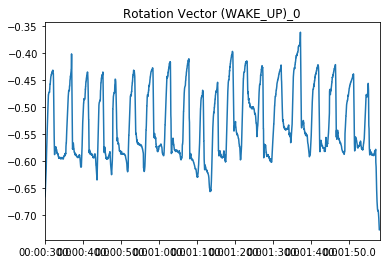

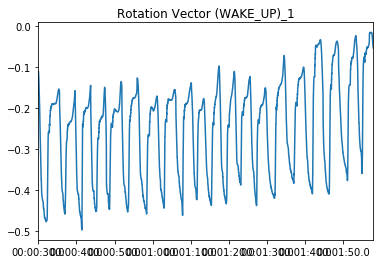

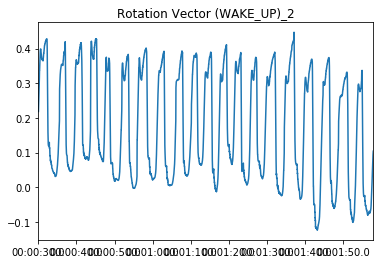

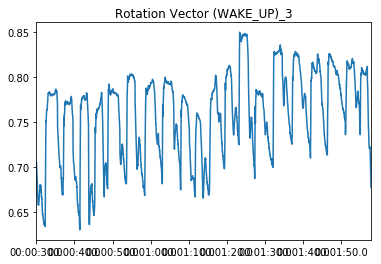

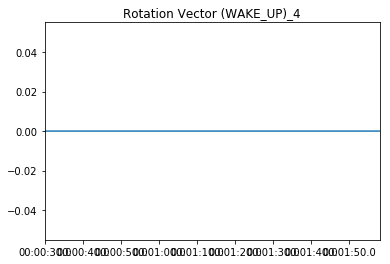

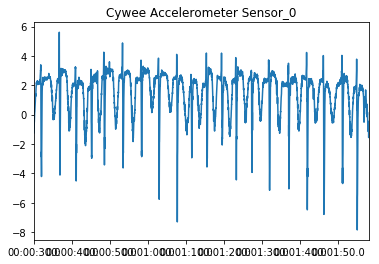

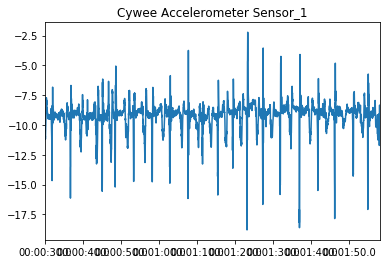

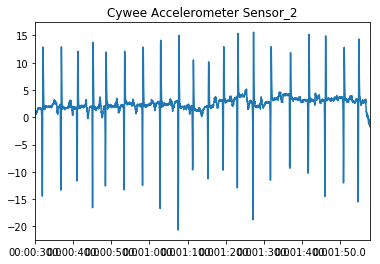

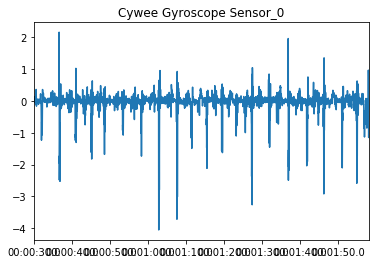

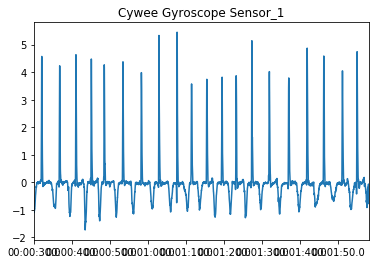

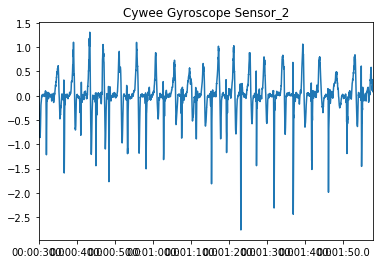

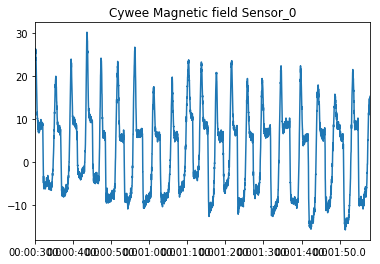

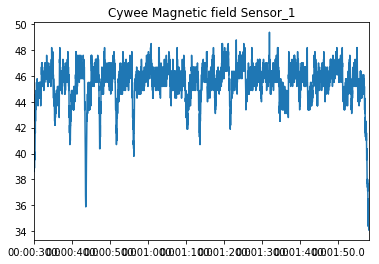

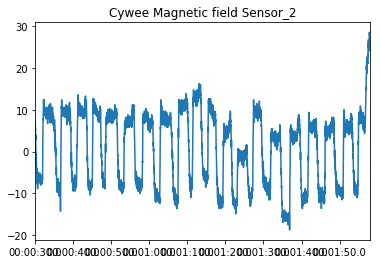

20 : [(30.98, 32.980000000000004), (35.82, 37.82), (40.12, 42.12), (44.14, 46.14), (47.56, 49.56), (52.44, 54.44), (57.3, 59.3), (61.9, 63.9), (66.68, 68.68), (70.52, 72.52), (74.52, 76.52), (78.5, 80.5), (82.2, 84.2), (86.32, 88.32), (90.94, 92.94), (96.0, 98.0), (100.88, 102.88), (105.24, 107.24), (110.12, 112.12), (113.98, 115.98)]
Found cuts: 20


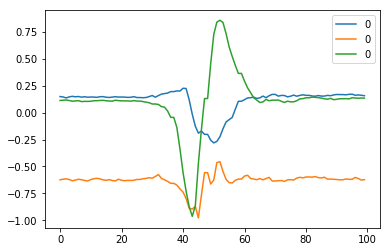

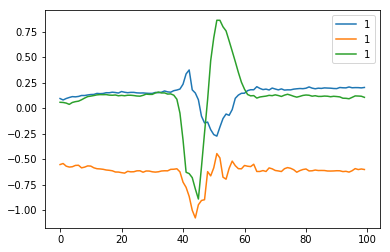

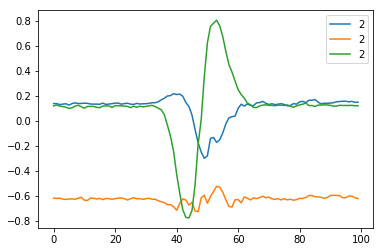

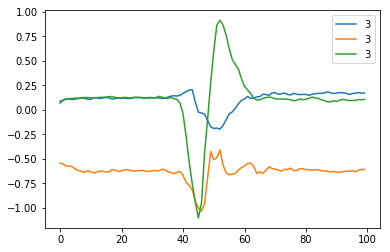

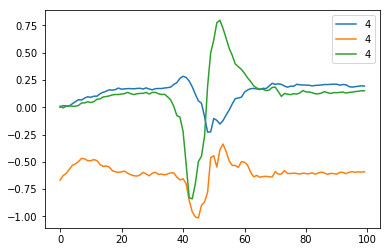

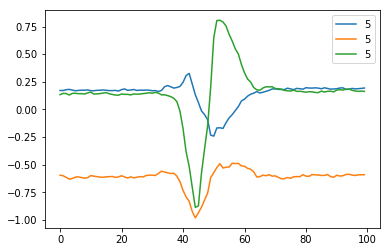

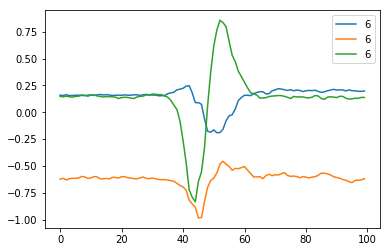

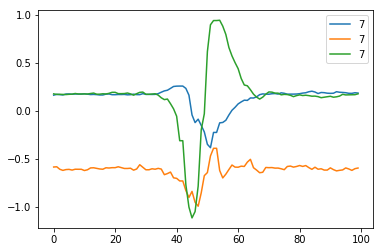

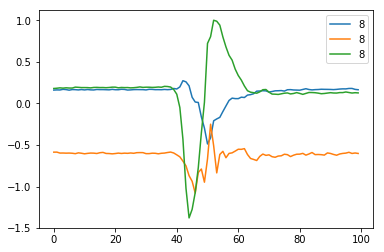

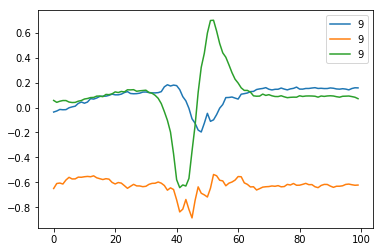

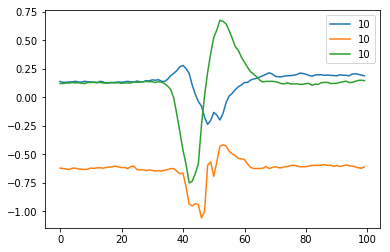

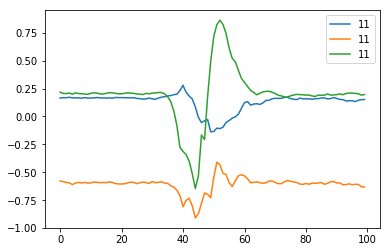

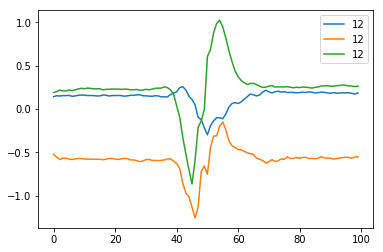

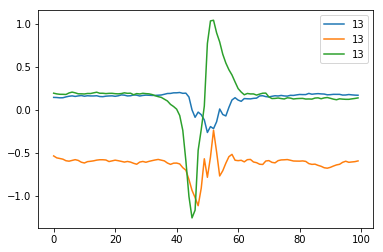

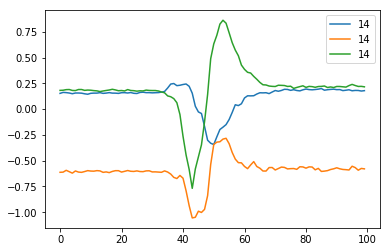

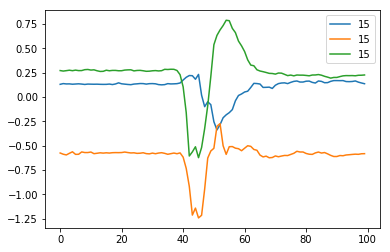

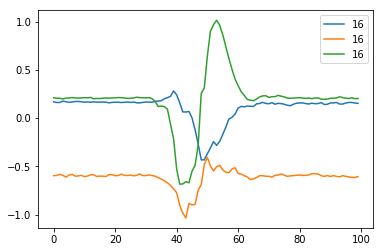

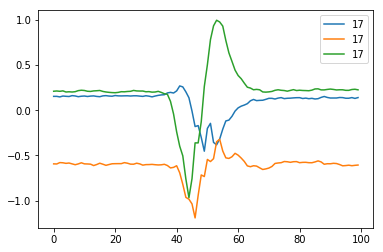

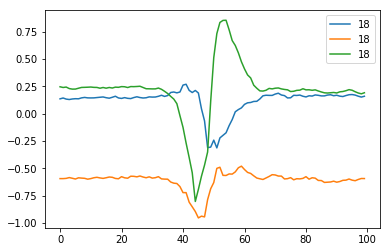

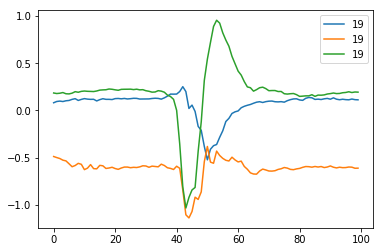

In [86]:
df, col_name_tpls = read_file("data/swipe_right_20_1.mkv")
trimed_df = trim_data(df, 30,118)
plot_dataframe(trimed_df, col_name_tpls)
peaks = find_peaks(trimed_df, "Cywee Accelerometer Sensor_2")
print(len(peaks), ":", peaks)
cuts = normalize_cuts(cut_data(trimed_df, peaks))
print("Found cuts:", len(cuts))
plot_cuts(cuts)

In [87]:
def  learn_clisifyer(data, lables):
    print(data.shape)
    model = keras.Sequential([
        #keras.layers.Flatten(),
        keras.layers.Flatten(input_shape=cut_shape),
        keras.layers.Dense(100 * len(normalize_vector), activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(data, lables, epochs=50)
    test_loss, test_acc = model.evaluate(data, lables)

    print('Test accuracy:', test_acc)
    
    return model

    



In [150]:
def prepare_learn_set(data_frame, previous_learned_data=None):
    peaks = find_peaks(data_frame, "Cywee Accelerometer Sensor_2")
    cuts = cut_data(data_frame, peaks)
    #cuts_full = [cut for cut in cuts if len(cut) == 100]
    learn_data = normalize_cuts(cuts) # Normalize
    print("DataShape:", learn_data.shape)
    
    if previous_learned_data is not None:
        learn_data = np.append(learn_data, previous_learned_data, axis=0)
    return learn_data
    
    

# Use Tensorflow to classify gestures

## Learn model


In [151]:
df, col_name_tpls = read_file("swipe_right_10_new.mkv")
trimed_df = trim_data(df, 52, 90)
learn_data_r = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("swipe_left_10.mkv")
trimed_df = trim_data(df, 10, 57)
learn_data_l = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("data/swipe_left_20_0.mkv")
trimed_df = trim_data(df, 15, 90)
learn_data_l = prepare_learn_set(trimed_df, learn_data_l)

df, col_name_tpls = read_file("random_noise.mkv")
trimed_df = trim_data(df, 0)
cuts = cut_data(trimed_df, [(i * 2, i*2+2) for i in range(50)])
learn_data_noise = normalize_cuts(cuts)
print("Noiseshape:", learn_data_noise.shape)
print("Learn L shape:", learn_data_l.shape)

learn_data = np.append(learn_data_noise, learn_data_l, axis=0)
learn_data = np.append(learn_data, learn_data_r, axis=0)

lables = [0]*len(learn_data_noise) + [1]*len(learn_data_l) + [2]*len(learn_data_r)

print("Learn data has shape: {}".format(learn_data.shape))
model = learn_clisifyer(learn_data, lables)


DataShape: (9, 100, 3)
DataShape: (9, 100, 3)
DataShape: (19, 100, 3)
Noiseshape: (50, 100, 3)
Learn L shape: (28, 100, 3)
Learn data has shape: (87, 100, 3)
(87, 100, 3)
Epoch 1/50
87/87 [==============================] - 0s 1ms/sample - loss: 0.9008 - acc: 0.6092
Epoch 2/50
87/87 [==============================] - 0s 98us/sample - loss: 0.4734 - acc: 0.8391
Epoch 3/50
87/87 [==============================] - 0s 195us/sample - loss: 0.3782 - acc: 0.8506
Epoch 4/50
87/87 [==============================] - 0s 107us/sample - loss: 0.3132 - acc: 0.9425
Epoch 5/50
87/87 [==============================] - 0s 100us/sample - loss: 0.2665 - acc: 0.9540
Epoch 6/50
87/87 [==============================] - 0s 150us/sample - loss: 0.2250 - acc: 0.9540
Epoch 7/50
87/87 [==============================] - 0s 99us/sample - loss: 0.1851 - acc: 0.9540
Epoch 8/50
87/87 [==============================] - 0s 153us/sample - loss: 0.1571 - acc: 0.9655
Epoch 9/50
87/87 [==============================] - 0s 11

# Test learned model
Test data has gestures:
Left, Left, Left, Left, Right, Right, Right, Left, Left

In [152]:
df, col_name_tpls = read_file("swipe_test_both.mkv")
trimed_df = trim_data(df, 10, 55)
test_data = prepare_learn_set(trimed_df) 
test_lables = [1, 1, 1, 1, 2, 2, 2, 1, 1]

predictions = model.predict(test_data)
print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[np.argmax(p)], 
                                         gestures[test_lables[i]], np.argmax(p) == test_lables[i]))

print('\nTest if noise will be predicted as noise')
df, col_name_tpls = read_file("data/noise_test.mkv")
trimed_df = trim_data(df, 16, 88)
learn_data_noise = prepare_learn_set(trimed_df)
noise_predictions = model.predict(learn_data_noise)
for p in noise_predictions:
    print(gestures[np.argmax(p)])

DataShape: (9, 100, 3)
Predicted:
0: Left should be Left -> True
1: Left should be Left -> True
2: Left should be Left -> True
3: Left should be Left -> True
4: Right should be Right -> True
5: Right should be Right -> True
6: Right should be Right -> True
7: Left should be Left -> True
8: Left should be Left -> True

Test if noise will be predicted as noise
DataShape: (21, 100, 3)
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Right
Noise
Noise
Noise


In [153]:
for p in predictions:
    print(max(p))

0.99872017
0.9983311
0.99888414
0.9989907
0.97667766
0.98972535
0.9396639
0.9985916
0.9974483


In [154]:
for p in noise_predictions:
    if np.argmax(p) != 0:
        print("classified as left or right with confidence {:.2f}%".format(max(p)*100))
    else:
        print("classified as noise,", max(p))

classified as noise, 0.6420587
classified as noise, 0.99475694
classified as noise, 0.9993168
classified as noise, 0.80315673
classified as noise, 0.7644724
classified as noise, 0.8212709
classified as noise, 0.9061711
classified as noise, 0.80299026
classified as noise, 0.80681205
classified as noise, 0.81489897
classified as noise, 0.8148656
classified as noise, 0.81396496
classified as noise, 0.8142793
classified as noise, 0.87628347
classified as noise, 0.743843
classified as noise, 0.9036623
classified as noise, 0.95769155
classified as left or right with confidence 43.54%
classified as noise, 0.6727254
classified as noise, 0.9686174
classified as noise, 0.7306943


# Train SVM:

## Define features

In [155]:
import sklearn.svm

def get_features(tf_learn_data, mode="features"):
    out_data = []
    for learn_data in tf_learn_data:
        feature_vec = []
        for split in range(15,101, 15):
            cur_split = learn_data[split-15:split+10]
            for i in range(3):
                sensor_data  = cur_split[:,i]
                feature_vec.append(sensor_data.mean())
                feature_vec.append(sensor_data.max())
                feature_vec.append(sensor_data.min())
                feature_vec.append(np.median(sensor_data))
        if mode == "features":
            out_data.append(feature_vec)
        elif mode == "raw":
            out_data.append(learn_data.flatten())
    return np.array(out_data)

## Train with features


In [156]:
X_train = get_features(learn_data)
y = lables

X_test = test_data
y_test = test_lables


clf = sklearn.svm.SVC(gamma=1.0, decision_function_shape='ovo', probability=True)
clf.fit(X_train, y) 
predictions = clf.predict(get_features(test_data))

print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[p], 
                                         gestures[y_test[i]], p == y_test[i]))

    
print(clf.predict(get_features(learn_data_noise)))

Predicted:
0: Left should be Left -> True
1: Left should be Left -> True
2: Left should be Left -> True
3: Left should be Left -> True
4: Right should be Right -> True
5: Right should be Right -> True
6: Right should be Right -> True
7: Left should be Left -> True
8: Left should be Left -> True
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [157]:
X_train.shape

(87, 72)

## Test on test data

 - tensorflow model
 - svm classifies

In [158]:
def predict_from_file(filename, mode="tensorflow", print_res=False):
    """
    pipeline including reading the file, running a classifier
    and outputting the results
    """
    df, col_name_tpls = read_file(filename)
    length = len(df) / 50
    trimed_df = trim_data(df, 5, length-1)
    test_data = prepare_learn_set(trimed_df)
    if mode == "tensorflow":
        res = model.predict(test_data)
    elif mode == "svm":
        res = clf.predict_proba(get_features(test_data))
    preds_and_confs = [(np.argmax(p), p[np.argmax(p)]) for p in res]
    if print_res:
        print([gestures[p[0]] for p in preds_and_confs])
    return np.array(preds_and_confs)

    

In [159]:
predict_from_file("swipe_test_both.mkv", "svm")


DataShape: (13, 100, 3)


array([[0.        , 0.91610035],
       [1.        , 0.92902826],
       [1.        , 0.93785605],
       [1.        , 0.92658277],
       [1.        , 0.93056516],
       [2.        , 0.58258111],
       [2.        , 0.60102517],
       [2.        , 0.55839149],
       [1.        , 0.96788939],
       [1.        , 0.96936122],
       [0.        , 0.75509204],
       [0.        , 0.95256175],
       [0.        , 0.95256483]])

In [160]:
predict_from_file("swipe_test_both.mkv", "tensorflow")

DataShape: (13, 100, 3)


array([[1.        , 0.6932897 ],
       [1.        , 0.99872017],
       [1.        , 0.99833113],
       [1.        , 0.99888414],
       [1.        , 0.99899071],
       [2.        , 0.97667766],
       [2.        , 0.98972535],
       [2.        , 0.93966389],
       [1.        , 0.9985916 ],
       [1.        , 0.99744833],
       [1.        , 0.95106757],
       [2.        , 0.67489409],
       [0.        , 0.42559874]])

In [161]:
predict_from_file("data/swipe_right_20_1.mkv", "tensorflow")

DataShape: (28, 100, 3)


array([[2.        , 0.53248304],
       [2.        , 0.88385129],
       [0.        , 0.99927419],
       [0.        , 0.99498665],
       [1.        , 0.93113226],
       [2.        , 0.99520481],
       [2.        , 0.98813277],
       [2.        , 0.99127746],
       [2.        , 0.98668694],
       [2.        , 0.99109602],
       [2.        , 0.99373335],
       [2.        , 0.99211359],
       [2.        , 0.99745327],
       [2.        , 0.99495125],
       [2.        , 0.96106273],
       [2.        , 0.99199778],
       [2.        , 0.98946661],
       [2.        , 0.99506289],
       [2.        , 0.99088871],
       [2.        , 0.99797302],
       [2.        , 0.99250132],
       [2.        , 0.99873704],
       [2.        , 0.99802268],
       [2.        , 0.99644864],
       [2.        , 0.99847227],
       [0.        , 0.49531567],
       [0.        , 0.90361202],
       [0.        , 0.91678095]])

In [ ]:
def live_demo(filename="data/live_demo.mkv"):
    import warnings
    warnings.filterwarnings("ignore")
    res_tf = predict_from_file(filename, "tensorflow")
    res_svm = predict_from_file(filename, "svm")
    
    res_tf = [gestures[p[0]] for p in res_tf if p[1] > 0.9]
    res_svm = [gestures[p[0]] for p in res_svm if p[1] > 0.5]
    print("\n\nPredictions:\n")
    """
    for i, gesture in enumerate(res_tf):
        print(i+1, ":", gesture, sep=" ")
    print("=" * 20)
    for i, gesture in enumerate(res_svm):
        print(i+1, ":", gesture, sep=" ")
    """
    df = pd.DataFrame(list(zip(res_tf, res_svm)), columns=["tensorflow", "SVC"])
    return df
    

In [162]:
res_df = live_demo("data/test_demo.mkv")
res_df

DataShape: (14, 100, 3)
DataShape: (14, 100, 3)


Predictions:



,tensorflow,SVC
0,Left,Noise
1,Right,Noise
2,Right,Noise
3,Left,Noise
4,Noise,Noise
5,Noise,Noise
6,Noise,Noise
7,Noise,Noise
8,Noise,Noise
